In [1]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np

from Utils import *
from constants import *

from Environment import *
from Non_Stationary_Environment import *

from Social_influence import *
from Network import Network

from Simulation import *

from Ecommerce import *
from Ecommerce3 import *
from Ecommerce4 import *
from Ecommerce5 import *
from Ecommerce6 import *
#from step7.Ecommerce7 import*

### Scenario Recap

In [ ]:
ecomm3_gpts, ecomm3_gpucb, env = observe_learned_functions()
plot_learned_functions(ecomm3_gpts, ecomm3_gpucb, env)

## Step 3

Experiment n°: 1


n_iteration: 100%|██████████| 80/80 [03:58<00:00,  2.98s/it]


Experiment n°: 2


n_iteration:  18%|█▊        | 14/80 [00:22<01:56,  1.76s/it]

OPTIMAL PULLED al round 13


n_iteration:  55%|█████▌    | 44/80 [01:34<01:53,  3.15s/it]

OPTIMAL PULLED al round 43


n_iteration:  57%|█████▊    | 46/80 [01:40<01:45,  3.11s/it]

OPTIMAL PULLED al round 45


n_iteration:  82%|████████▎ | 66/80 [02:52<00:56,  4.02s/it]

OPTIMAL PULLED al round 65


n_iteration:  88%|████████▊ | 70/80 [03:10<00:44,  4.47s/it]

OPTIMAL PULLED al round 69


n_iteration:  94%|█████████▍| 75/80 [03:33<00:23,  4.73s/it]

OPTIMAL PULLED al round 74


n_iteration: 100%|██████████| 80/80 [03:59<00:00,  3.00s/it]


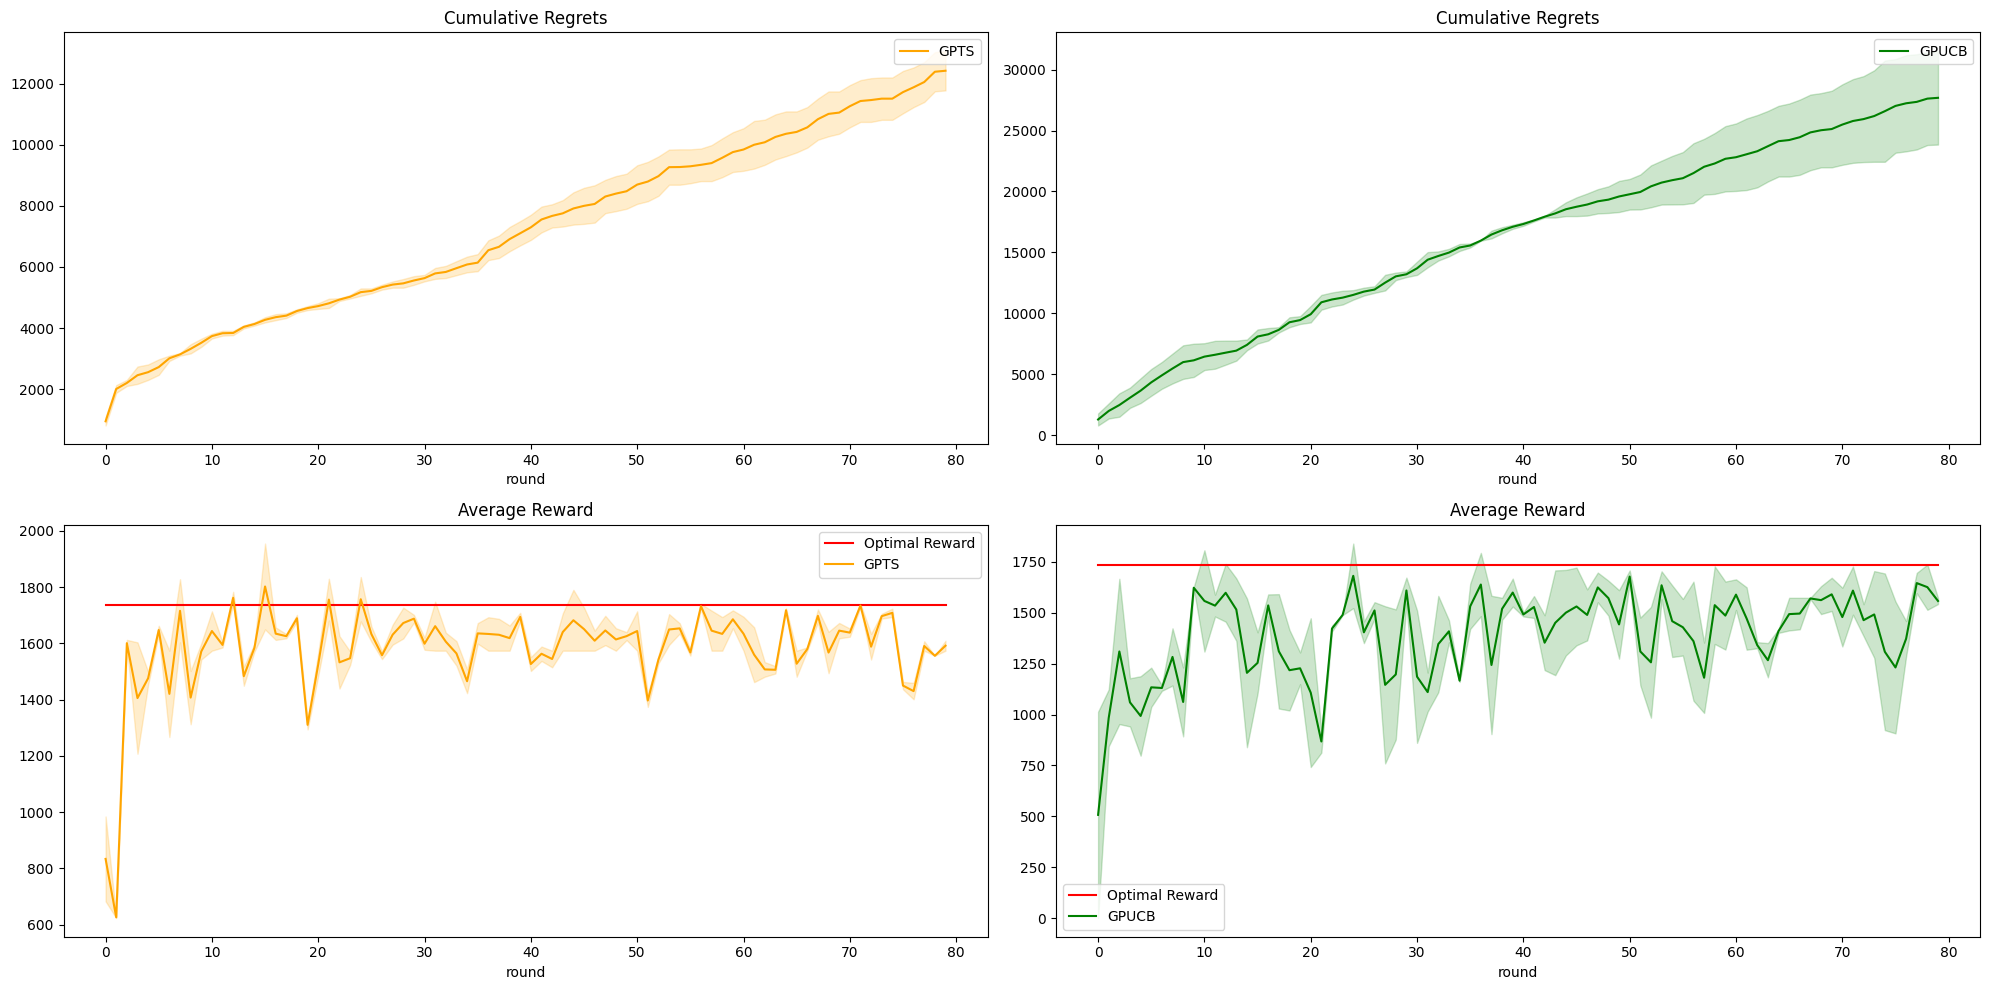

In [1]:
from Simulation import *

gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step3()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

In [ ]:
plot_rewards_for_each_experiment(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 4

Experiment n°: 1


n_iteration: 100%|██████████| 80/80 [02:02<00:00,  1.54s/it]


Experiment n°: 2


n_iteration: 100%|██████████| 80/80 [02:01<00:00,  1.52s/it]


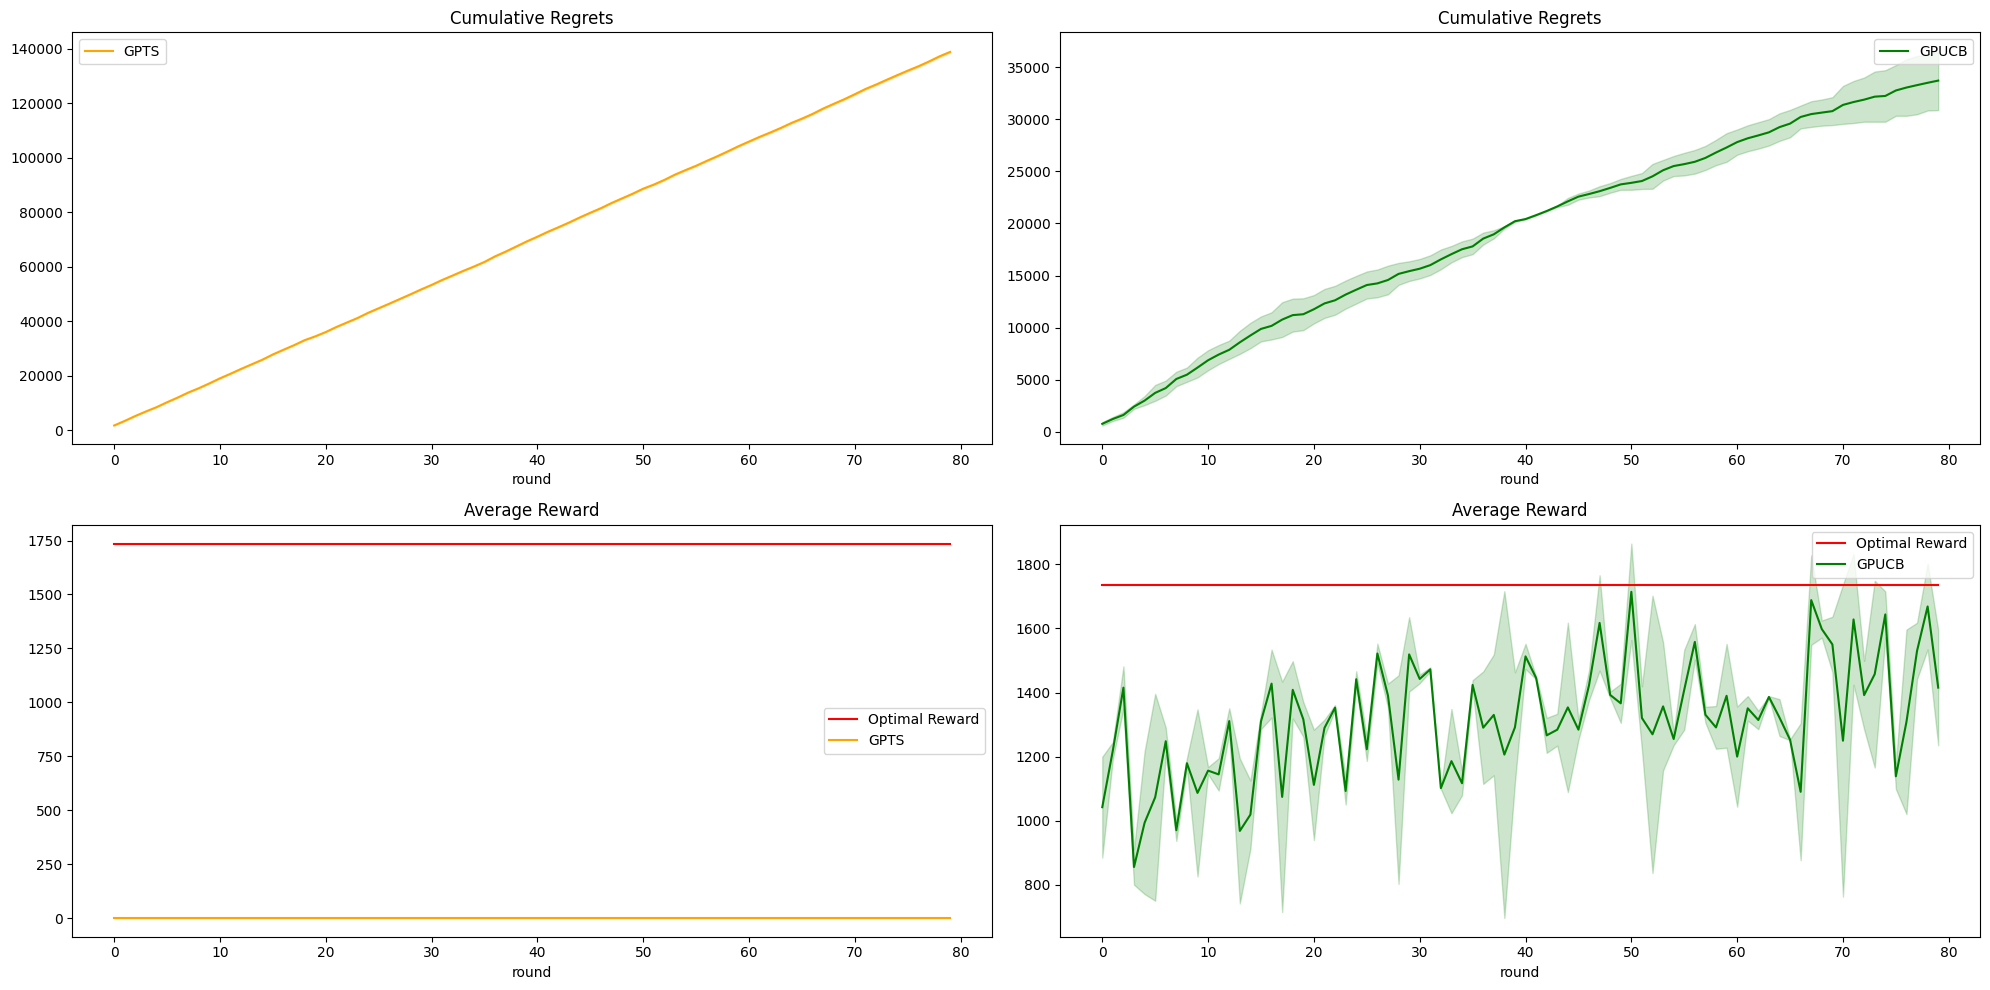

In [2]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step4()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 5

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step5()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 6

tau : 44
M, h, eps: 15, 1.0, 0.005;

Experiment n° 1


n_iteration:  35%|███▌      | 74/210 [01:48<04:29,  1.98s/it]

Change detected at time t = 73


n_iteration:  70%|███████   | 147/210 [03:28<01:48,  1.73s/it]

Change detected at time t = 146


Experiment n° 2


n_iteration:  36%|███▌      | 75/210 [02:05<05:50,  2.60s/it]

Change detected at time t = 74


n_iteration:  70%|██████▉   | 146/210 [03:41<02:20,  2.19s/it]

Change detected at time t = 146


n_iteration:  87%|████████▋ | 183/210 [04:15<00:26,  1.02it/s]

Change detected at time t = 108


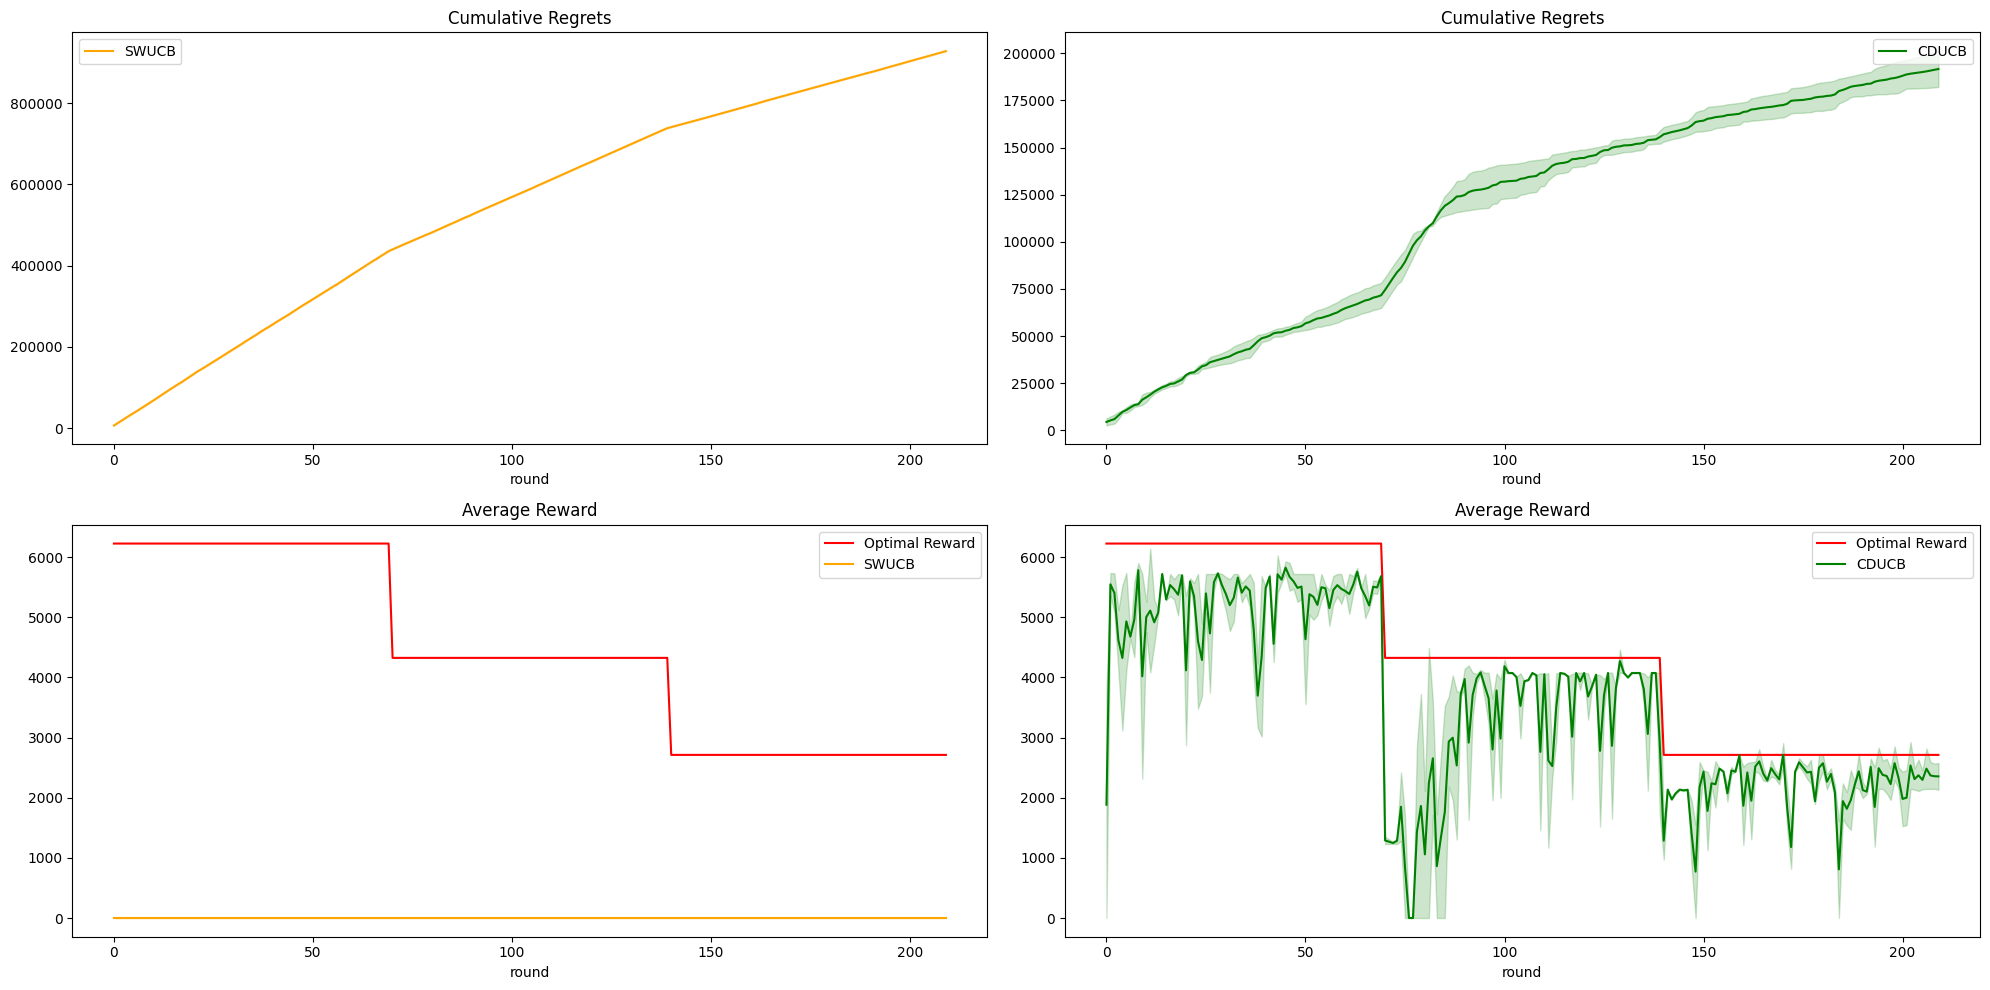

In [1]:
from Simulation import *

swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, n_phases, phase_len = simulate_step6()
plot_regrets_step6(swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, ["SWUCB", "CDUCB"], n_phases, phase_len)

## Step 7

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step7()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Hyperparams Tuning

In [ ]:
! python gp_parameter_optimizer.py